# Threshold Adjustment

👇 Load the player `player_performances.csv` dataset to see what you will be working with.

In [1]:
import pandas as pd
import numpy as np

In [2]:
player = pd.read_csv("data/player_performances.csv")
player.head()

,games played,minutes played,points per game,field goals made,field goal attempts,field goal percent,3 point made,3 point attempt,3 point %,free throw made,free throw attempts,free throw %,offensive rebounds,defensive rebounds,rebounds,assists,steals,blocks,turnovers,target_5y
0,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


ℹ️ Each observations represents a player and each column a characteristic of performance. The target `target_5y` defines whether the player has had a professional career of less than 5 years [0] or 5 years or more [1].

# Preprocessing

👇 To avoid spending too much time on the preprocessing, Robust Scale the entire feature set. This practice is not optimal, but can be used for preliminary preprocessing and/or to get models up and running quickly.

Save the scaled feature set as `X_scaled`.

In [3]:
from sklearn.preprocessing import RobustScaler

target = 'target_5y'
features = list(player.columns)
features.remove(target)

for col in features:
    rs = RobustScaler()
    rs.fit(player[[col]])
    player[col] = rs.transform(player[[col]])

X_scaled = player[['games played', 'minutes played', 'points per game', 'field goals made',
       'field goal attempts', 'field goal percent', '3 point made',
       '3 point attempt', '3 point %', 'free throw made',
       'free throw attempts', 'free throw %', 'offensive rebounds',
       'defensive rebounds', 'rebounds', 'assists', 'steals', 'blocks',
       'turnovers']]

### ☑️ Check your code

In [4]:
from nbresult import ChallengeResult

result = ChallengeResult('scaled_features',
                         scaled_features = X_scaled
)

result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/03-Performance-metrics/03-Threshold-Adjustments
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_scaled_features.py::TestScaled_features::test_scaled_features PASSED [100%]

============================== 1 passed in 0.37s ===============================


💯 You can commit your code:

git add tests/scaled_features.pickle

git commit -m 'Completed scaled_features step'

git push origin master


# Base modelling

🎯 The task is to detect players who will last 5 years minimum as professionals, with a 90% guarantee.

👇 Is a default Logistic Regression model going to satisfy the coach's requirements? Use cross validation and save the score that supports your answer under variable name `base_score`.

In [12]:
y = player[target]

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

cv = cross_validate(estimator = LogisticRegression(), X=X_scaled, y=y, scoring = 'precision')
base_score = cv['test_score'].mean()
base_score


0.7346247634876919

### ☑️ Check your code

In [17]:
from nbresult import ChallengeResult

result = ChallengeResult('base_precision',
                         score = base_score
)

result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/03-Performance-metrics/03-Threshold-Adjustments
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_base_precision.py::TestBase_precision::test_precision_score PASSED [100%]

============================== 1 passed in 0.08s ===============================


💯 You can commit your code:

git add tests/base_precision.pickle

git commit -m 'Completed base_precision step'

git push origin master


# Threshold adjustment

👇 Find the decision threshold that guarantees a 90% precision for a player to last 5 years or more as a professional. Save the threshold under variable name `new_threshold`.

<details>
<summary>💡 Hint</summary>

- Make cross validated probability predictions with [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)
    
- Plug the probabilities into [`precision_recall_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) to generate precision scores at different thresholds

- Find out which threshold guarantees a precision of 0.9
      
</details>



In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=300)

# Predict class probabilties
player['prob_less'], player['prob_more'] =cross_val_predict(model,
                                                              X_scaled,
                                                              player[target],
                                                              cv=5,
                                                              method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(player[target],
                                                      player['prob_more']) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.62292609 0.62264151 0.62311178 0.62358277 0.62405446]
recall- [1.         0.99878935 0.99878935 0.99878935 0.99878935]
threshold- [0.07674062 0.09561194 0.10298152 0.10620172 0.11859761]


Text(0.5, 0, 'seuil')

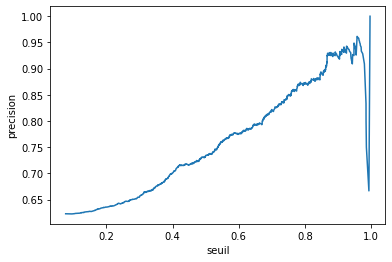

In [23]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})# Store in dataframe
plt.plot(scores['threshold'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('seuil')

In [29]:
new_threshold = scores[scores['precision'] >= 0.9].threshold.min()
new_threshold

0.8626977113268592

### ☑️ Check your code

In [30]:
from nbresult import ChallengeResult

result = ChallengeResult('decision_threshold',
                         threshold = new_threshold
)

result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/03-Performance-metrics/03-Threshold-Adjustments
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_decision_threshold.py::TestDecision_threshold::test_new_threshold PASSED [100%]

============================== 1 passed in 0.08s ===============================


💯 You can commit your code:

git add tests/decision_threshold.pickle

git commit -m 'Completed decision_threshold step'

git push origin master


# Using the new threshold

🎯 The coach has spotted a potentially interesting player, but wants your 90% guarantee that he would last 5 years minimum as a pro. Download the player's data [here](https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_New_player.csv).

❓ Would you risk recommending the player to the coach? Save your answer as string under variable name `recommendation` as "recommend" or "not recommend".

In [36]:
new_player = pd.read_csv("data/new_player.csv")

model = LogisticRegression()
model.fit(X_scaled,y)



def custom_predict(X, custom_threshold):
    probs = model.predict_proba(X) # Get likelihood of each sample being classified as 0 or 1
    expensive_probs = probs[:, 1] # Only keep expensive likelihoods (1) 
    return (expensive_probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1
    
    
updated_preds = custom_predict(X=new_player, custom_threshold=new_threshold) # Update predictions 

recommendation = 'recommend' if updated_preds== 1 else "not recommand"

### ☑️ Check your code

In [37]:
from nbresult import ChallengeResult

result = ChallengeResult('recommendation',
                         recommendation = recommendation
)

result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/03-Performance-metrics/03-Threshold-Adjustments
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_recommendation.py::TestRecommendation::test_recommendation PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/recommendation.pickle

git commit -m 'Completed recommendation step'

git push origin master


# 🏁